In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Download the data and extract the feature matrix X
dataset = fetch_openml(data_id=42803, as_frame=True)
df_X = dataset["frame"]
print('Dataset shape before cleaning:', df_X.shape)

# Change datatype of features where needed
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")

# Combine features and create new ones where needed
df_X["Timestamp"] = pd.to_datetime(df_X["Date"] + " " + df_X["Time"])
df_X = df_X.drop(labels=["Date", "Time"], axis=1)
df_X["day_of_week"] = df_X["Timestamp"].dt.day_of_week
df_X["hour_of_day"] = df_X["Timestamp"].dt.hour

# Drop duplicates based on 'columns_to_consider'
columns_to_consider = df_X.drop(labels=["Accident_Index"], axis=1).columns
df_X = df_X.drop_duplicates(subset=columns_to_consider)

# Drop missing values based on feature and sample axis
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.75, axis=0)
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)

# Rest the index numbering
df_X = df_X.reset_index(drop=True)

# Dropping some entries according to some feature criteria
entries_to_drop = df_X["Number_of_Vehicles"].gt(30)
df_X = df_X[~entries_to_drop]

# Remove entries of the 10 most frequent accidents
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])
accident_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index
df_X = df_X[~df_X["Accident_Index"].isin(accident_ids)]
print('Dataset shape after cleaning:', df_X.shape)

Dataset shape before cleaning: (363243, 67)
Dataset shape after cleaning: (317659, 61)


In [13]:
import numpy as np

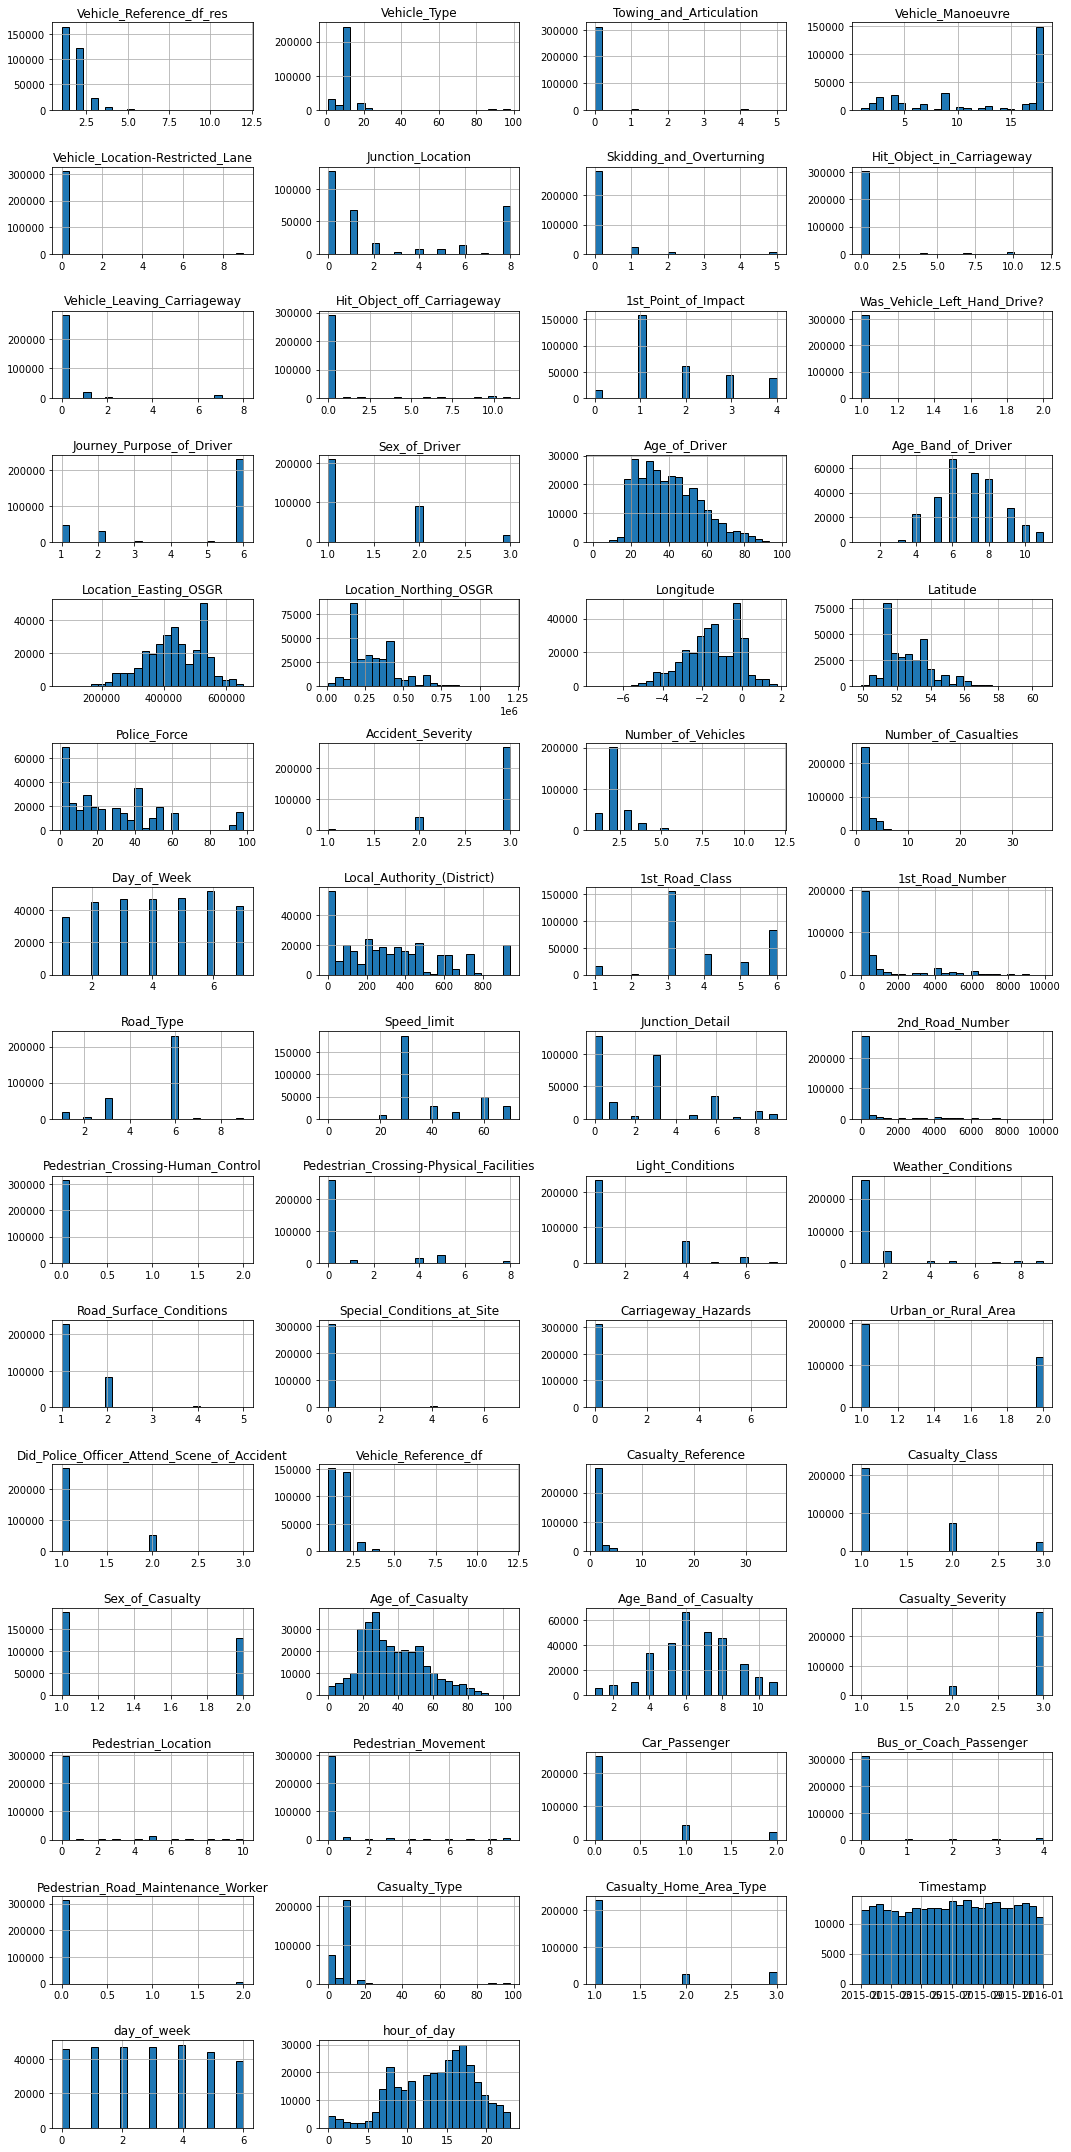

In [2]:
import matplotlib.pyplot as plt

# Plots the histogram for each numerical feature in a separate subplot
df_X.hist(bins=25, figsize=(15, 30), layout=(-1, 4), edgecolor="black")
plt.tight_layout()

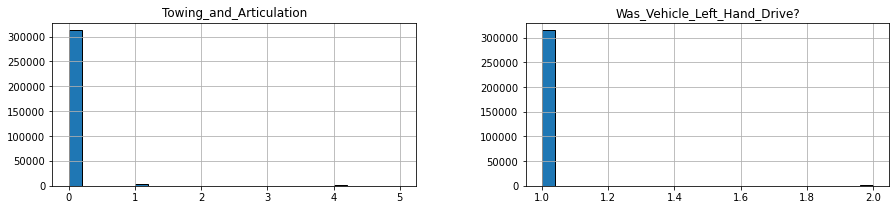

In [3]:
# Show histogram of two particular features
df_X[["Towing_and_Articulation", "Was_Vehicle_Left_Hand_Drive?"]].hist(
    bins=25, figsize=(15, 3), layout=(-1, 2), edgecolor="black");

In [4]:
df_X[["Towing_and_Articulation", "Was_Vehicle_Left_Hand_Drive?"]].mode()

,Towing_and_Articulation,Was_Vehicle_Left_Hand_Drive?
0,0.0,1.0


In [5]:
# Collects for each feature the most frequent entry
most_frequent_entry = df_X.mode()

# Checks for each entry if it contains the most frequent entry
df_freq = df_X.eq(most_frequent_entry.values, axis=1)

# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)

# Show the 5 top features with the highest ratio of singular value content
df_freq.head()

Pedestrian_Crossing-Human_Control    0.995155
Was_Vehicle_Left_Hand_Drive?         0.990336
Carriageway_Hazards                  0.983548
Towing_and_Articulation              0.983073
Vehicle_Location-Restricted_Lane     0.981943
dtype: float64

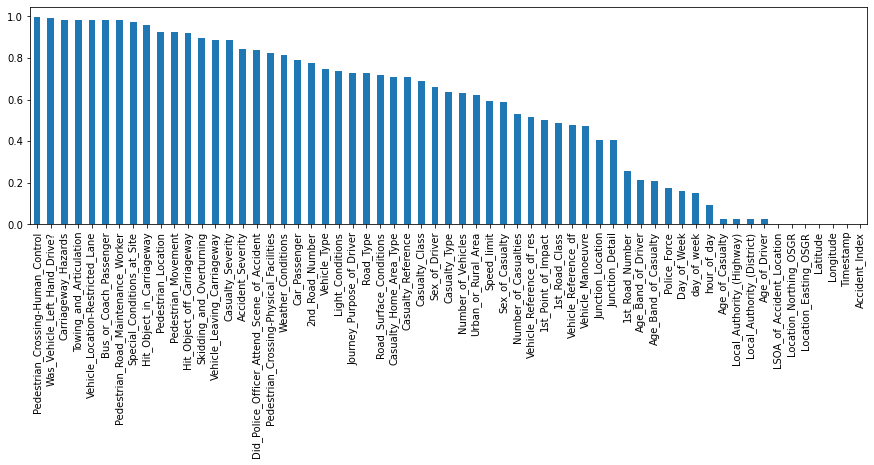

In [7]:
df_freq.plot.bar(figsize=(15, 4));

In [8]:
# Shape of feature matrix before cleaning
print("Shape before cleaning:", df_X.shape)

# Loop through the indices where 'most_frequent_ratio' is great than 99%
for col in df_freq[df_freq > 0.99].index:

    # Only keep entries that correspond to the majority value
    df_X = df_X[df_X[col].isin(most_frequent_entry[col])]

    #  Remove feature
    df_X = df_X.drop(columns=col)

# Shape of feature matrix after cleaning
print("Shape after cleaning:", df_X.shape)

Shape before cleaning: (317659, 61)
Shape after cleaning: (313061, 59)


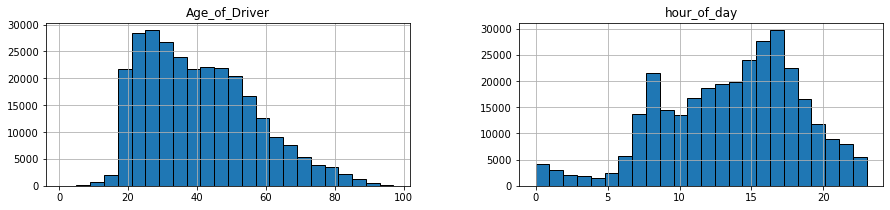

In [9]:
# look at two more interesting features

# Show histogram of two particular features
df_X[["Age_of_Driver", "hour_of_day"]].hist(
    bins=24, figsize=(15, 3), layout=(-1, 2), edgecolor="black");

In [11]:
# remove drivers under age 16

df_X = df_X[~df_X["Age_of_Driver"].lt(16)]
df_X.shape

(311175, 59)

In [14]:
# Establish new feature name and value boundaries
new_features = {
    "night": [0, 6],
    "morning": [6, 11],
    "lunch": [11, 14],
    "afternoon": [14, 19],
    "evening": [19, 24],
}

# Loop through new features and add them to the feature matrix
for key, value in new_features.items():
    df_X[key] = np.logical_and(
        df_X["hour_of_day"] >= value[0], df_X["hour_of_day"] < value[1]
    ).astype("int")

df_X.shape

(311175, 64)

In [15]:
# Show the top few missing values
df_X.isna().sum().sort_values(ascending=False).head(5)

Casualty_Home_Area_Type      35334
Age_of_Driver                31428
Age_Band_of_Driver           31428
LSOA_of_Accident_Location    20419
Age_of_Casualty               4962
dtype: int64

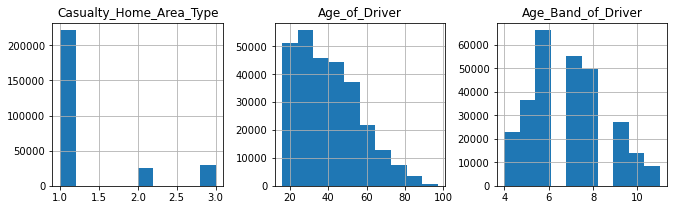

In [16]:
df_X[["Casualty_Home_Area_Type", "Age_of_Driver",
      "Age_Band_of_Driver", "LSOA_of_Accident_Location"]].hist(
    layout=(-1, 4), figsize=(15, 3));

In [19]:
# check contents of 4th entry

df_X["LSOA_of_Accident_Location"]

0         E01002825
1         E01002820
2         E01002833
3         E01002874
4         E01002814
            ...    
319751         None
319752         None
319753         None
319754         None
319755         None
Name: LSOA_of_Accident_Location, Length: 311175, dtype: object

In [20]:
# Select non-numerical columns
non_numb_col = df_X.select_dtypes(include="object").columns

# Fill up missing values in non-numerical columns
df_X[non_numb_col] = df_X[non_numb_col].fillna("None")

# Check for remaining missing values
df_X[non_numb_col].isna().sum()

Accident_Index               0
Local_Authority_(Highway)    0
LSOA_of_Accident_Location    0
dtype: int64

In [21]:
# Extract columns to fill up
cols = df_X.columns[df_X.isna().sum() != 0]

# Loop through each column and fill up with missing values
cols_median = df_X[cols].nunique() >= 25

# Fill discrete entries with most frequent entry
df_X[cols[~cols_median]] = df_X[cols[~cols_median]].fillna(
    df_X[cols[~cols_median]].mode().T[0])

# Fill continuous features with median value
df_X[cols[cols_median]] = df_X[cols[cols_median]].fillna(
    df_X[cols[cols_median]].median(numeric_only=True))

In [22]:
# Show the top few missing values
df_X.isna().sum().sort_values(ascending=False).head(5)

Timestamp               43
Accident_Index           0
Age_Band_of_Casualty     0
Light_Conditions         0
Weather_Conditions       0
dtype: int64

In [23]:
df_X["Timestamp"] = df_X["Timestamp"].fillna(method="ffill").fillna(method="bfill")

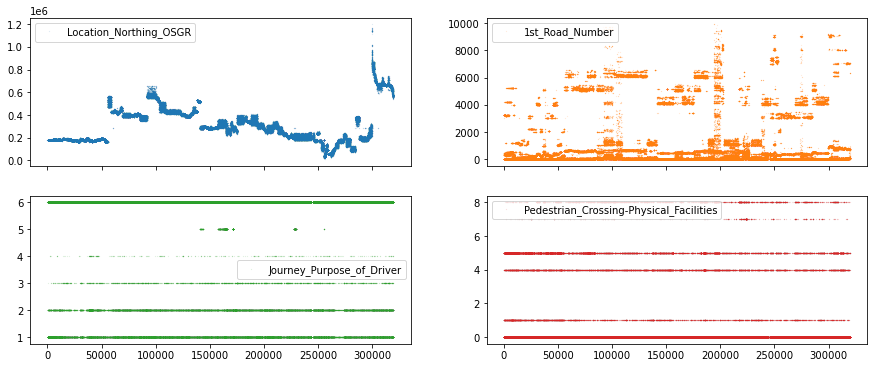

In [24]:
df_X[["Location_Northing_OSGR", "1st_Road_Number",
      "Journey_Purpose_of_Driver", "Pedestrian_Crossing-Physical_Facilities"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6));

In [25]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = df_X.select_dtypes(include="number").nunique() >= 25

In [26]:
# Create a new dataframe which only contains the continuous features
df_continuous = df_X[cols_continuous[cols_continuous].index]
df_continuous.shape

(311175, 11)

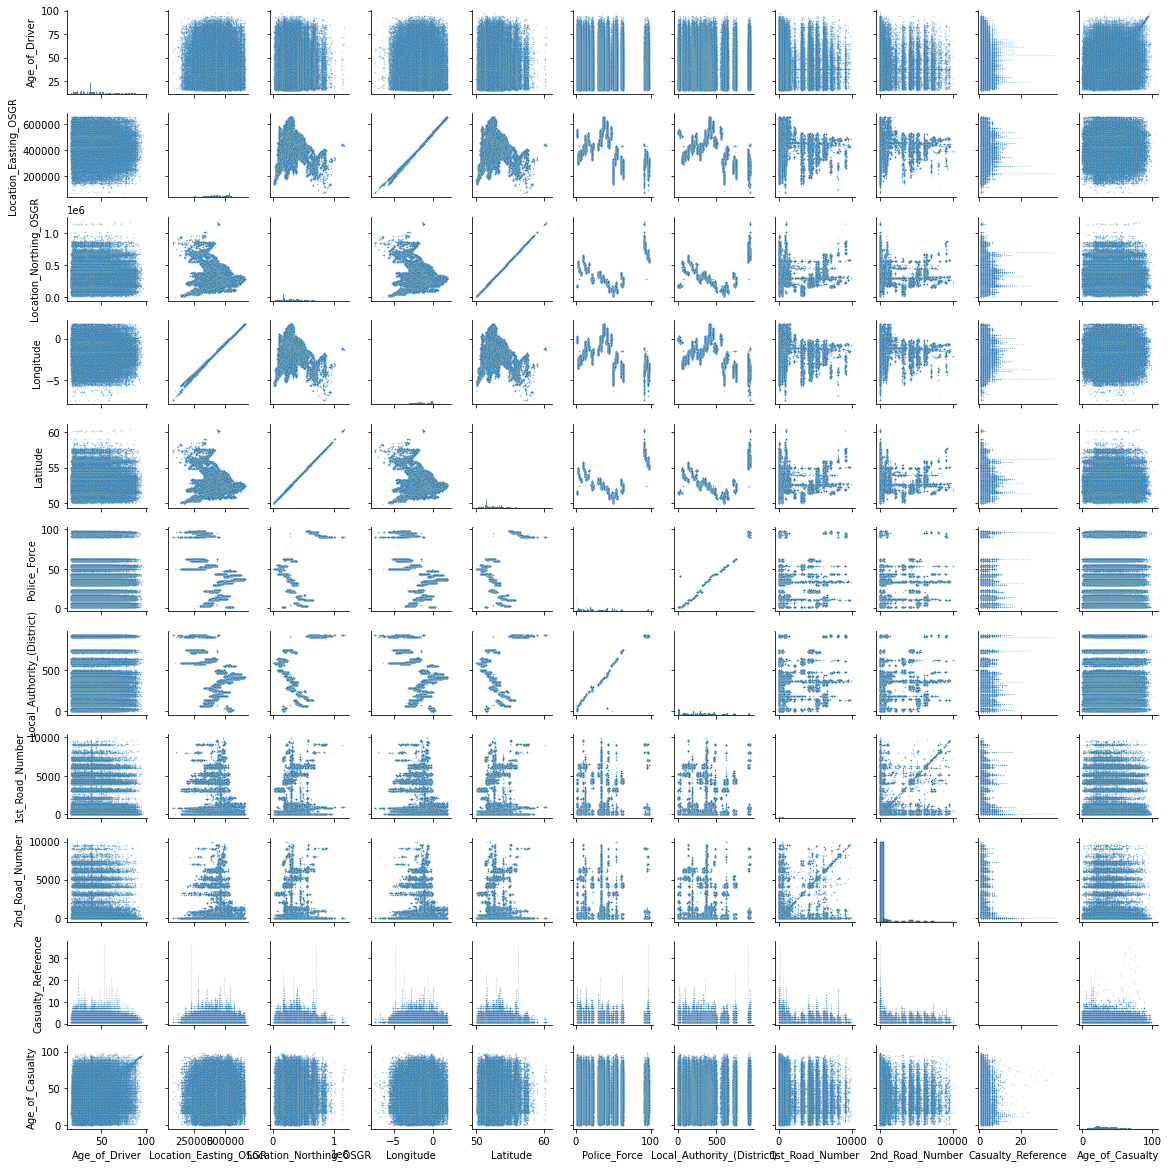

In [27]:
import seaborn as sns

sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2});

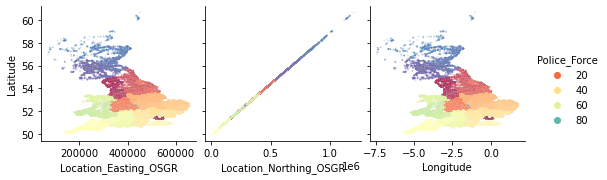

In [28]:
sns.pairplot(
    df_X,
    plot_kws={"s": 3, "alpha": 0.2},
    hue="Police_Force",
    palette="Spectral",
    x_vars=["Location_Easting_OSGR", "Location_Northing_OSGR", "Longitude"],
    y_vars="Latitude",
);

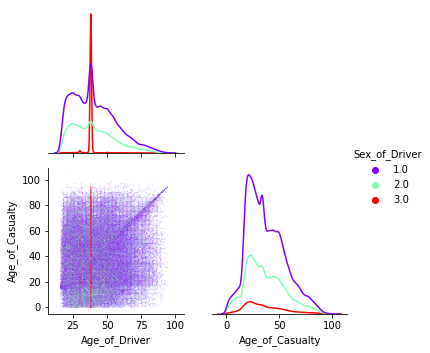

In [29]:
# Select the two columns of interest
col_vars = ["Age_of_Driver", "Age_of_Casualty"]

# Specify which feature should be chosen to color the plot
col_color = "Sex_of_Driver"

#  Use PairGrid to plot features
g = sns.PairGrid(
    df_X,
    diag_sharey=False,
    corner=True,
    hue=col_color,
    x_vars=col_vars,
    y_vars=col_vars,
    palette="rainbow",
)
g.map_lower(sns.scatterplot, s=1, alpha=0.2)
g.map_diag(sns.kdeplot)
g.add_legend();

In [30]:
# Create a new dataframe which doesn't contain the numerical continuous features
df_discrete = df_X[cols_continuous[~cols_continuous].index]
df_discrete.shape

(311175, 49)

In [31]:
# Establish number of columns and rows needed to plot all features
n_cols = 5
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")
print(n_cols, n_rows)

5 10


In [32]:
# Specify y_value (ideally a continuous feature)
y_value = df_X["Age_of_Driver"]

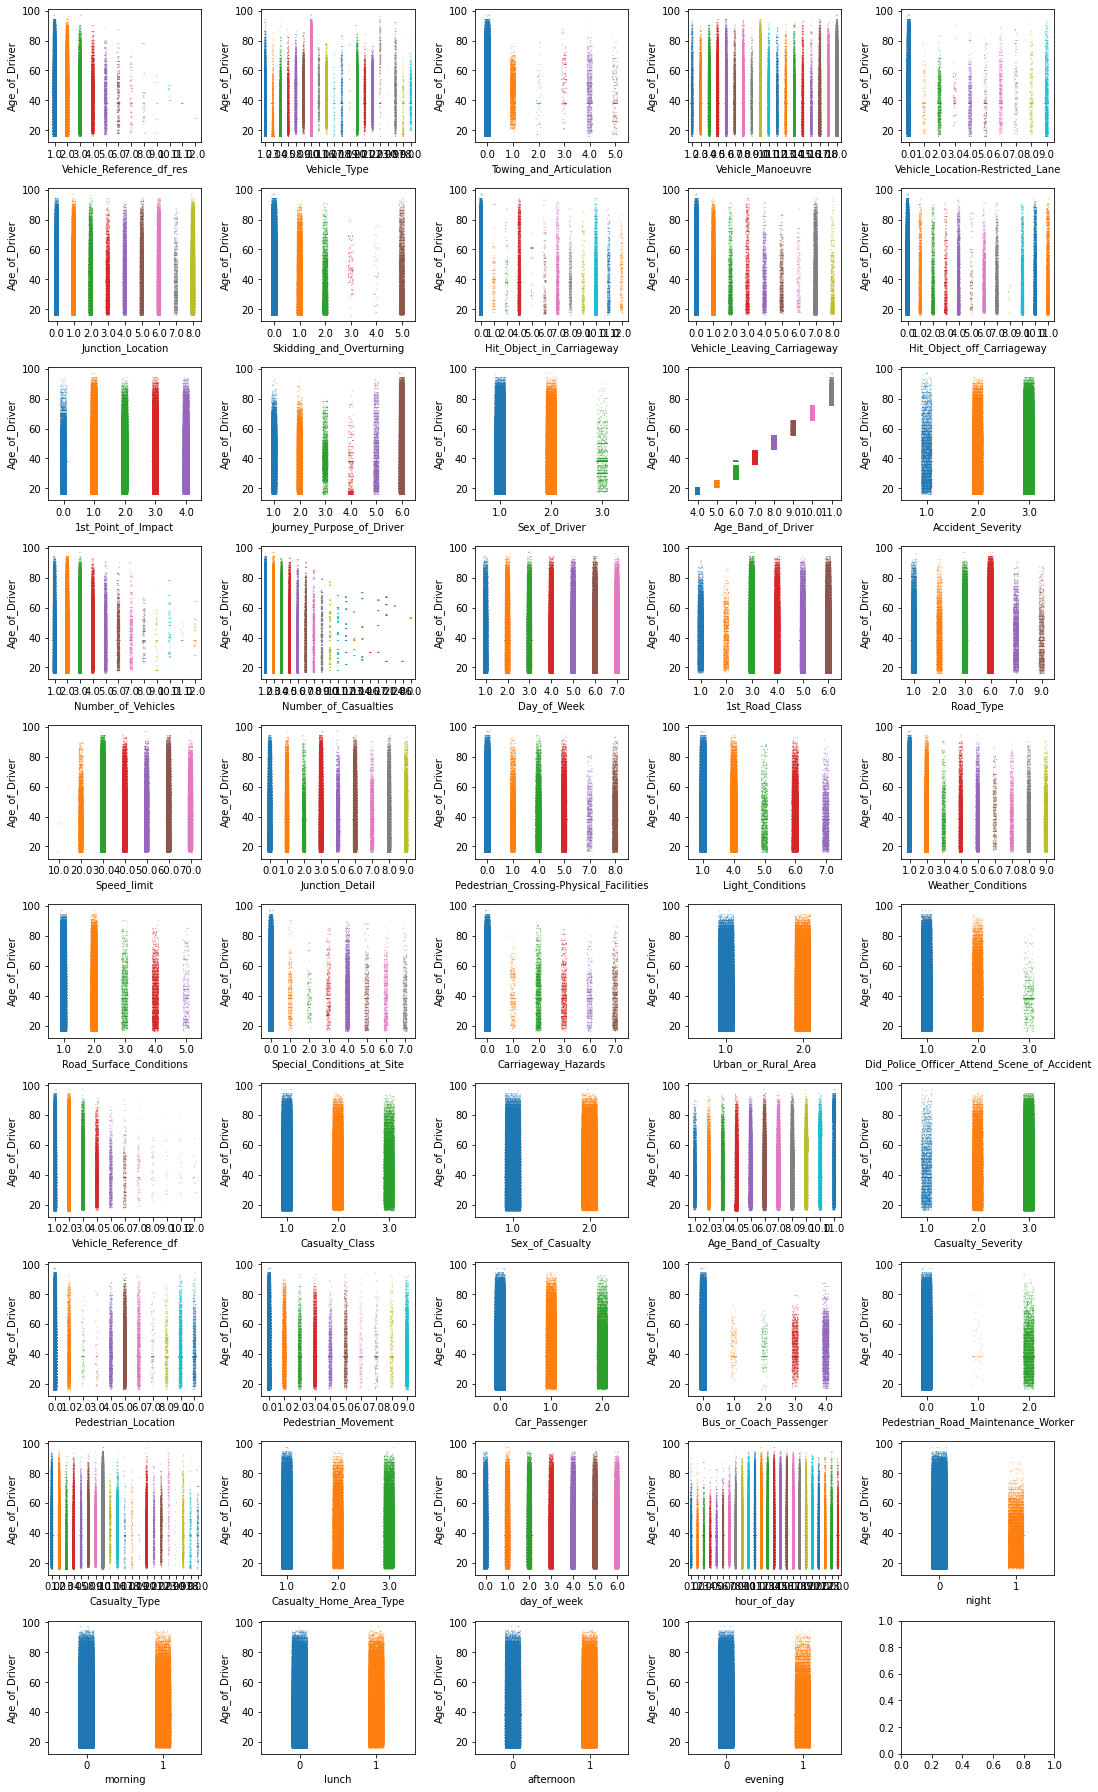

In [33]:
# Create figure object with as many rows and columns as needed
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, n_rows * 2.5))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df_X, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
plt.tight_layout()

In [34]:
# Specify features of interest
selected_features = ["Vehicle_Reference_df_res", "Towing_and_Articulation",
                     "Skidding_and_Overturning", "Bus_or_Coach_Passenger",
                     "Pedestrian_Road_Maintenance_Worker", "night"]

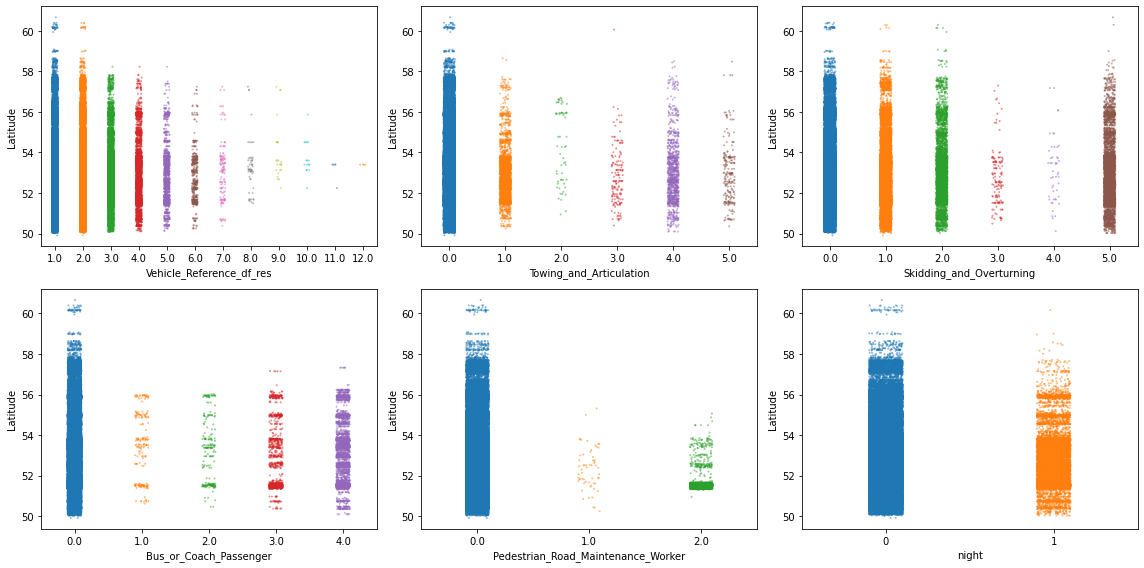

In [35]:
# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.stripplot(data=df_X, x=col, y=df_X["Latitude"], ax=ax, palette="tab10", size=2, alpha=0.5)
plt.tight_layout()

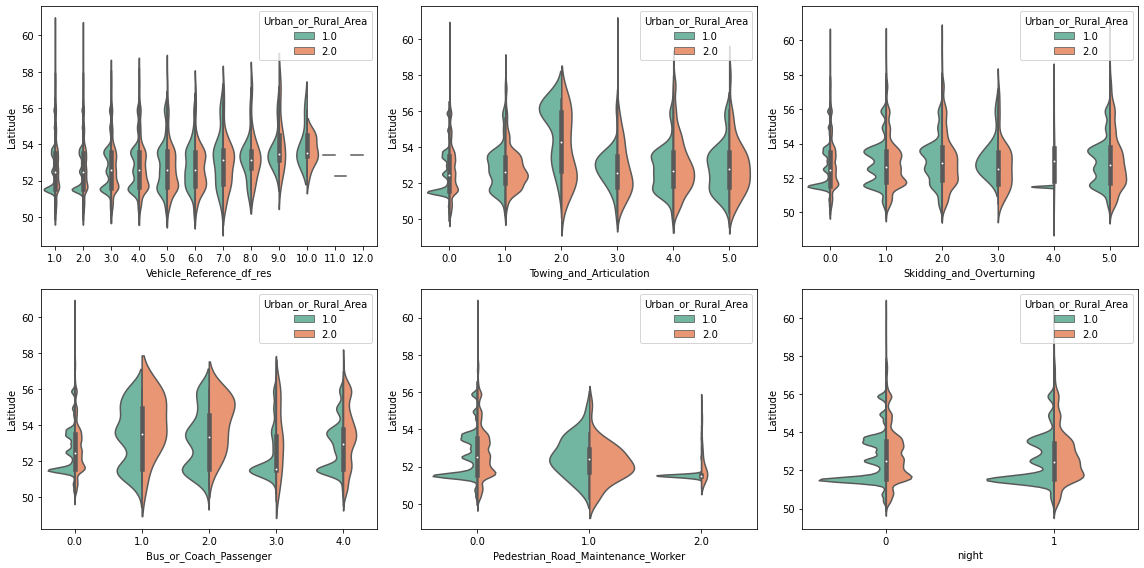

In [36]:
# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(
        data=df_X,
        x=col,
        y=df_X["Latitude"],
        ax=ax,
        palette="Set2",
        split=True,
        hue="Urban_or_Rural_Area",
    )
plt.tight_layout()

In [37]:
df_corr = df_X.corr(method="pearson")
df_corr.round(3)

,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,...,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,day_of_week,hour_of_day,night,morning,lunch,afternoon,evening
Vehicle_Reference_df_res,1.000,0.013,0.005,-0.128,-0.013,-0.078,-0.105,-0.074,-0.106,-0.110,...,-0.101,0.097,0.010,-0.003,-0.002,-0.031,0.008,0.010,0.023,-0.032
Vehicle_Type,0.013,1.000,0.126,-0.043,0.008,-0.061,0.007,-0.016,0.003,0.003,...,-0.002,0.423,0.029,-0.012,-0.035,0.007,0.018,0.022,-0.012,-0.030
Towing_and_Articulation,0.005,0.126,1.000,0.015,0.000,-0.031,0.036,-0.002,0.002,0.002,...,-0.011,0.057,0.035,-0.010,-0.020,0.005,0.010,0.015,-0.011,-0.015
Vehicle_Manoeuvre,-0.128,-0.043,0.015,1.000,-0.050,0.038,0.141,0.082,0.128,0.132,...,0.026,-0.014,0.042,0.014,-0.006,0.047,-0.000,-0.032,-0.025,0.038
Vehicle_Location-Restricted_Lane,-0.013,0.008,0.000,-0.050,1.000,-0.014,-0.007,0.040,0.015,0.013,...,0.009,-0.030,-0.012,-0.001,-0.006,0.007,0.003,-0.001,-0.001,-0.004
Junction_Location,-0.078,-0.061,-0.031,0.038,-0.014,1.000,-0.082,-0.029,-0.060,-0.078,...,-0.006,-0.066,-0.086,-0.006,0.015,-0.014,0.014,-0.015,-0.020,0.035
Skidding_and_Overturning,-0.105,0.007,0.036,0.141,-0.007,-0.082,1.000,0.143,0.247,0.279,...,-0.034,0.059,0.076,0.018,-0.025,0.072,-0.003,-0.020,-0.036,0.029
Hit_Object_in_Carriageway,-0.074,-0.016,-0.002,0.082,0.040,-0.029,0.143,1.000,0.199,0.193,...,-0.005,0.016,-0.004,0.020,-0.016,0.080,-0.015,-0.018,-0.036,0.038
Vehicle_Leaving_Carriageway,-0.106,0.003,0.002,0.128,0.015,-0.060,0.247,0.199,1.000,0.532,...,-0.031,0.062,0.080,0.015,-0.019,0.081,-0.014,-0.020,-0.037,0.039
Hit_Object_off_Carriageway,-0.110,0.003,0.002,0.132,0.013,-0.078,0.279,0.193,0.532,1.000,...,-0.031,0.061,0.078,0.019,-0.024,0.094,-0.015,-0.021,-0.045,0.045


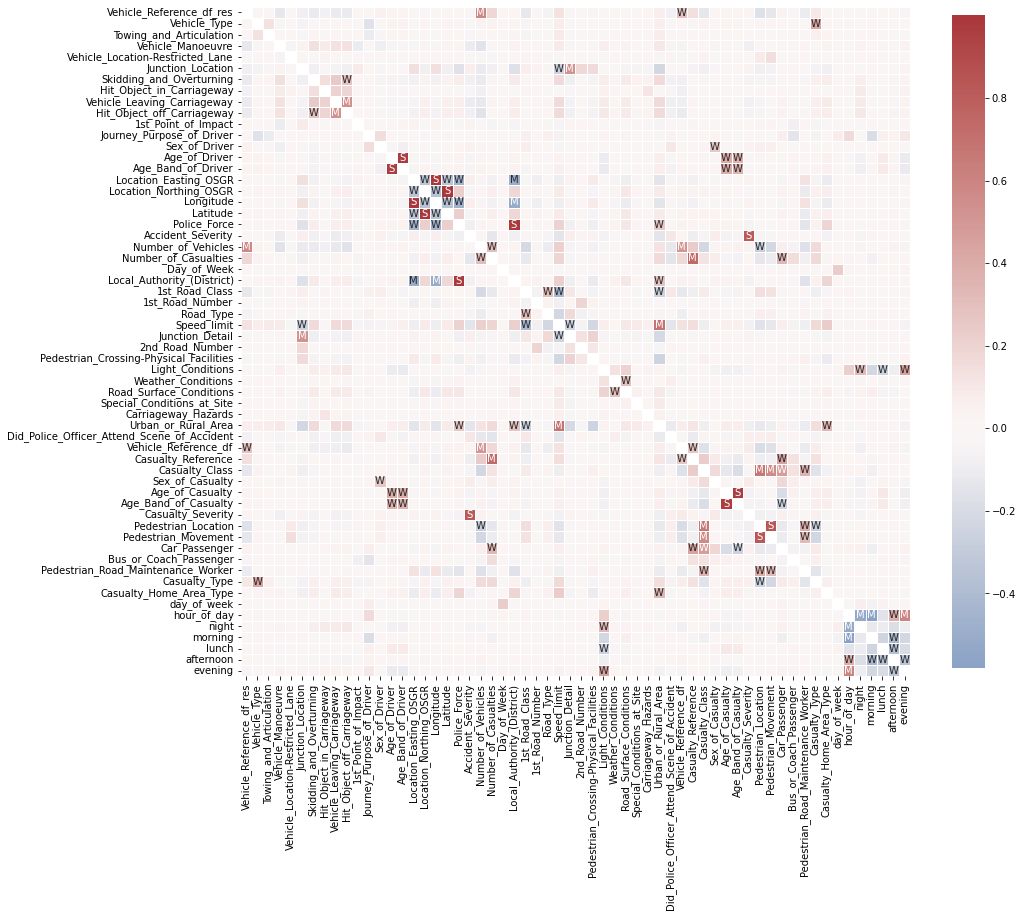

In [38]:
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75,'S',
                  np.where(np.abs(df_corr)>0.5,'M',
                           np.where(np.abs(df_corr)>0.25,'W','')))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

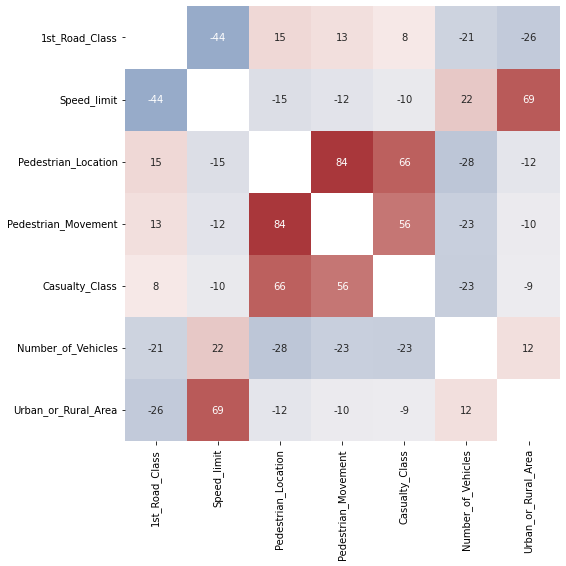

In [39]:
# Select which features to look at
features = ["1st_Road_Class", "Speed_limit", "Pedestrian_Location", "Pedestrian_Movement",
            "Casualty_Class", "Number_of_Vehicles", "Urban_or_Rural_Area"]

#  Redo correlation matrix (this time only on the selected features)
df_detail = df_X[features].corr(method="pearson")

# Plot the correlation matrix, with annotation and without colorbar
plt.figure(figsize=(8, 8))
sns.heatmap(df_detail * 100, annot=True, fmt=".0f", mask=np.eye(len(df_detail)),
            square=True, center=0, cmap="vlag", cbar=False);

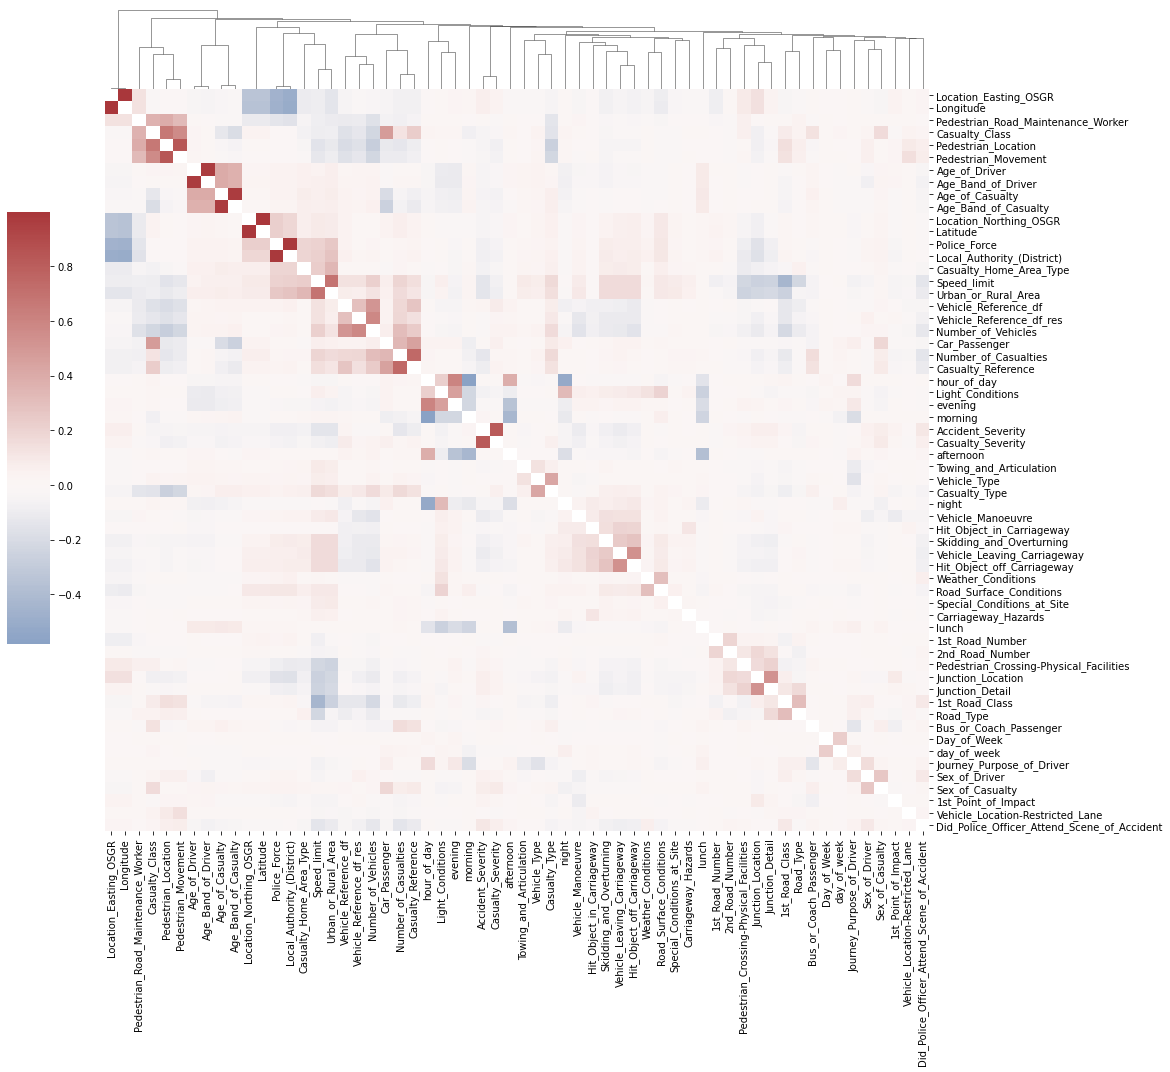

In [40]:
sns.clustermap(df_corr, mask=np.eye(len(df_corr)), center=0, cmap="vlag",
               cbar_pos=(-0.08, 0.4, 0.04, 0.4), dendrogram_ratio=(0, 0.1),
               figsize=(15, 15));

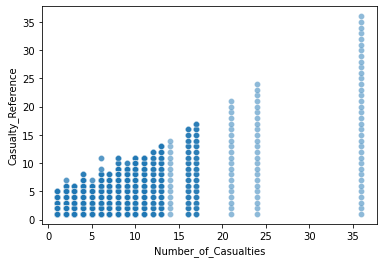

In [41]:
sns.scatterplot(data=df_X, x="Number_of_Casualties", y="Casualty_Reference", alpha=0.5);

In [42]:
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")
lower_triangle_mask

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False]])

In [43]:
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

In [44]:
df_corr_stacked.head(10)

morning                     hour_of_day             -0.580871
night                       hour_of_day             -0.523233
Local_Authority_(District)  Longitude               -0.511528
                            Location_Easting_OSGR   -0.505144
Police_Force                Longitude               -0.473569
                            Location_Easting_OSGR   -0.463393
Speed_limit                 1st_Road_Class          -0.436120
afternoon                   morning                 -0.428474
                            lunch                   -0.372048
Latitude                    Longitude               -0.363044
dtype: float64

In [45]:
df_corr_stacked.tail(10)

Pedestrian_Location         Casualty_Class            0.661509
Urban_or_Rural_Area         Speed_limit               0.685887
Casualty_Reference          Number_of_Casualties      0.742381
Casualty_Severity           Accident_Severity         0.826200
Pedestrian_Movement         Pedestrian_Location       0.838741
Age_Band_of_Driver          Age_of_Driver             0.973257
Age_Band_of_Casualty        Age_of_Casualty           0.974436
Local_Authority_(District)  Police_Force              0.984810
Longitude                   Location_Easting_OSGR     0.999363
Latitude                    Location_Northing_OSGR    0.999974
dtype: float64